# Predicting Forest Coverage Type to Predict Ecological Shifts

by: Carter Koehler

## Data Description and Prediction Task

This dataset contains information on the forest coverage types from the Roosevelt National Forest in Colorado. The data consists of $12$ explanatory variables related to cartographic measurements of a particular area and a categorical encoding of what type of tree cover that area has. In particular, it has features on:

- elevation
- grade of slope (slope)
- direction of slope (aspect)
- distance to water
- distance to roads
- distance to fire points
- shade coverage at various times in the day
- wilderness area
- soil type

All of the categorical data (with the exception of the target variable) has already been one-hot encoded, meaning the the data we are dealing with already has quite a few more than $12$ columns.

All of this is well and good, but it begs the question why we would want to be able to predict the forest coverage of a particular block of forest. One possible application is as follows: If it happens that we are able to predict how a particular area of forest is covered, this gives us a good qualitative description of what flora is present in that area. However, if the cartographic features of that area were to change due to human or other influence, such that we would predict a different coverage type than is there currently, we should predict that that area is about to go through a severe ecological change. This will give administrators and rangers a chance to prepare for major changes in the forest's wildlife. Unfortunately, this application is difficult to test for directly, so we will settle for predicting the classes as is.

This of course brings into question what we might use as a suitable baseline. We will see in the exploratory stages of the analysis that the distribution of cover type changes significantly between wilderness areas. We will use this to derive our baseline, which will predict the most frequent cover type for each wilderness area. For our algorithm to be considered as successfully fulfilling our task, it should be able to beat this baseline to within a statistically significant.

## Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['axes.grid'] = True

import os

In [2]:
filename = os.path.join(os.pardir, 'data', 'covtype.csv')
df_cov = pd.read_csv(filename)

# get an idea of what data looks like
display(df_cov.describe())
display(df_cov.info())

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Wilderness_Area1                      581012 non-null int64
Wilderness_Area2                      581012 non-null int64
Wilderness_Area3                      581012 non-null int64
Wilderness_Area4                      581012 non-null int64
Soil_Type1                            581012 non-

None

Clearly, much of this data has already been one-hot encoded. This would be convenient if we didn't have ambitions to visualize the data. Anyways, let's press onward regardless of the state of our data. At least there isn't anything missing.

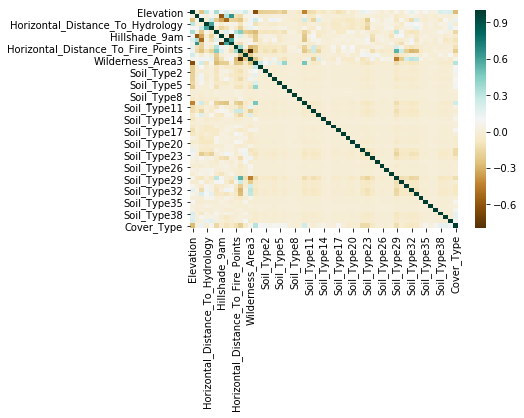

In [3]:
sns.heatmap(df_cov.corr(), cmap=plt.cm.BrBG)

This heatmap is enormous, and some of the labels are getting cut off. We'll try removing the one-hot encoded data and looking at the heatmap again.

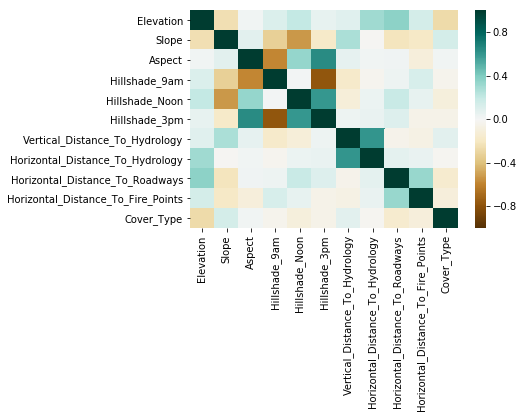

In [4]:
non_one_hot = ['Elevation', 'Slope', 'Aspect', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Cover_Type']

sns.heatmap(df_cov.filter(non_one_hot).corr(), vmin=-1, cmap=plt.cm.BrBG)

Most of the variables are only weakly correlated. However, it bears recalling that the variable we hope to predict, cover_type, is categorical, so we shouldn't expect it to have  any meaningful correlations anyways. And the purpose behind using a neural network is to be able to detect highly nonlinear relationships, which a simple correlation coefficient would never be able to detect.

Let's look at a few more variables, then get started classifying.

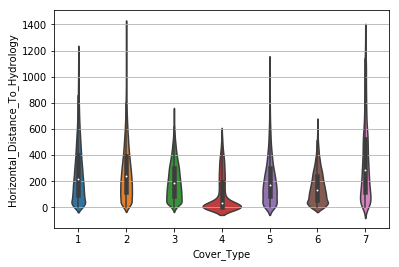

In [5]:
sns.violinplot(data=df_cov, x='Cover_Type', y='Horizontal_Distance_To_Hydrology')

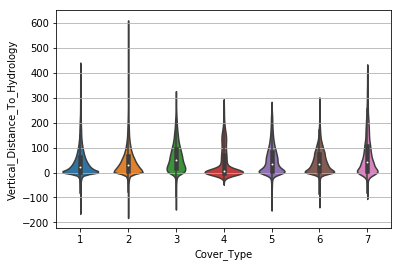

In [6]:
sns.violinplot(data=df_cov, x='Cover_Type', y='Vertical_Distance_To_Hydrology')

These plots aren't overly interesting, except that we may note that cover type 4 has base-heavy distributions, and cover types 2 and 7 have heavy-tailed distributions.

One thing that likely will be interesting, and possibly important for balancing purposes, is to visualize the proportions of some of our categorical variables.

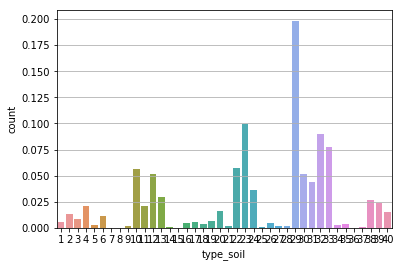

In [7]:
soil_types = ['Soil_Type' + str(i) for i in range(1,41)]

soil_counts = pd.DataFrame(np.zeros((len(soil_types), 2)), index=soil_types, columns=['type_soil', 'count'])
soil_counts['type_soil'] = range(1,41)
for soil in soil_types:
    soil_counts.loc[soil, 'count'] = df_cov[soil].sum() / df_cov[soil].count()
    
sns.barplot(data=soil_counts, x='type_soil', y='count')

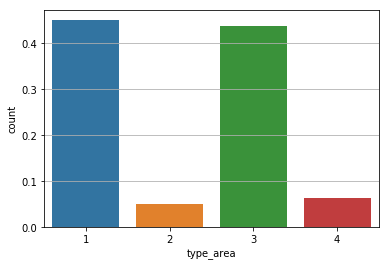

In [8]:
area_types = ['Wilderness_Area' + str(i) for i in range(1,5)]

area_counts = pd.DataFrame(np.zeros((len(area_types), 2)), index=area_types, columns=['type_area', 'count'])
area_counts['type_area'] = range(1,5)
for area in area_types:
    area_counts.loc[area, 'count'] = df_cov[area].sum() / df_cov[area].count()
    
sns.barplot(data=area_counts, x='type_area', y='count')

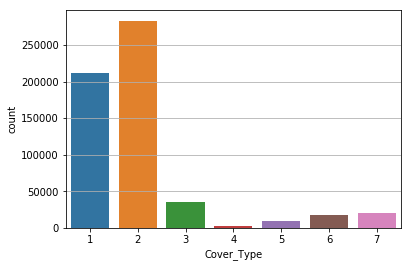

In [9]:
sns.countplot(data=df_cov, x='Cover_Type')

It appears as though our prediction classes are horribly unbalanced. This will need to be corrected for at some point, and may require the use of a different evaluation metric than just accuracy. 

One other thing that is apparent from the larger heatmap (though perhaps difficult to see) is that wilderness area and cover type are somewhat related. Let's pull up this relationship so we can visualize it.

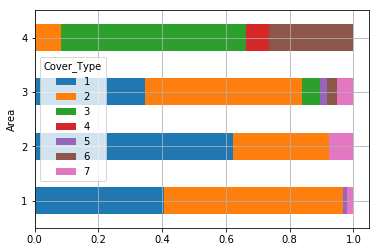

In [10]:
import re

# based on code from https://github.com/eclarson/MachineLearningNotebooks/blob/master/03.%20DataVisualization.ipynb

areas = df_cov.filter(['Wilderness_Area1', 'Wilderness_Area2', 
                       'Wilderness_Area3', 'Wilderness_Area4'])
areas['Area'] = areas.idxmax(1).apply(lambda phrase : re.search(r'\d', phrase).group())

areas_by_type = pd.crosstab([areas['Area']], df_cov['Cover_Type'])

cover_rate = areas_by_type.div(areas_by_type.sum(axis=1).astype(float),
                               axis=0) # normalize the value

# print survival_rate
cover_rate.plot(kind='barh', stacked=True)

Here, we see that, indeed, the distributions of cover type are very different among the wilderness areas. In particular, the modes for most of the wilderness areas (which we will use as our baseline are very different, with 1 being most prevalent in area 2, type 2 being most frequent in areas 1 and 3, and type 3 in area 4. As mentioned in the introduction, this is what our baseline will be based on.

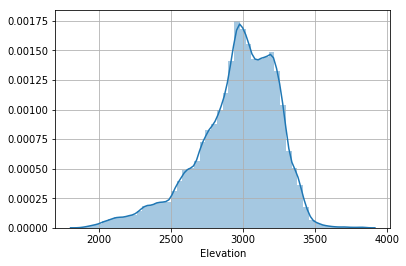

In [11]:
sns.distplot(df_cov.Elevation)

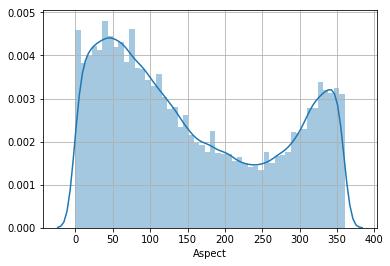

In [12]:
sns.distplot(df_cov.Aspect)

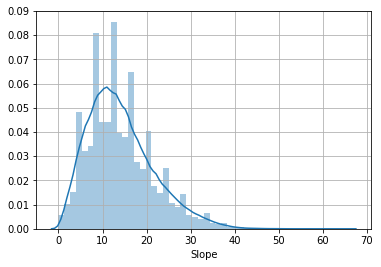

In [13]:
sns.distplot(df_cov.Slope)

These distributions don't tell us much. Everything is pretty nicely distributed, with no egregious spikes or extreme values.

This is probably enough that we can get started on our actual analysis. Let's divide up the set in data and target, then get on with it.

In [14]:
cov_data = np.array(df_cov.drop('Cover_Type', axis=1))
cov_target = np.array(df_cov.Cover_Type)

## Model Evaluation

Before we do anything else, we should decide how we will evaluate our model once it is actually built. First, let's construct our baseline.

In [15]:
area_cov = {'1':2, '2':1, '3':1, '4':3}
area_to_cov = lambda area : area_cov[area]

baseline = areas.Area.apply(area_to_cov)

### Picking a Metric

In [16]:
from sklearn.metrics import accuracy_score, f1_score

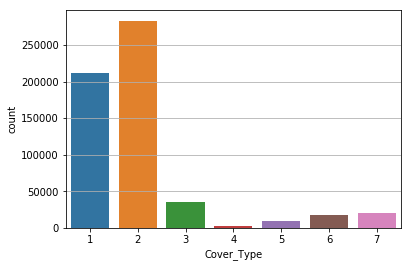

In [17]:
# a plot from earlier

sns.countplot(data=df_cov, x='Cover_Type')

We saw this plot earlier, in the exploratory stages of the analysis, but it bears recreating it here. Because our classes are so imbalanced, an evaluation metric like accuracy is not going to be appropriate for this analysis.

To demonstrate this, let's hypothesize a classifier that always predicts classes $1$ and $2$ correctly.

In [18]:
high_accuracy = np.array(cov_target)
high_accuracy[high_accuracy > 2] = 0

print('Accuracy if we always predict 1 and 2 correctly is: {}'.format(accuracy_score(cov_target, high_accuracy)))

Accuracy if we always predict 1 and 2 correctly is: 0.8522044295126434


In [19]:
print('Baseline accuracy: {}'.format(accuracy_score(cov_target, baseline)))

Baseline accuracy: 0.4712019717320813


Accuracy would tell us that this actually a pretty good classifier. It certainly beats the baseline by a wide margin. But let's try another popular metric, the $f_1$ score with a macro average.

In [20]:
print('F-1 if we always predict 1 and 2 correctly is: {}'.format(f1_score(cov_target, high_accuracy, average='macro')))
print('Baseline F1: {}'.format(f1_score(cov_target, baseline, average='macro')))

F-1 if we always predict 1 and 2 correctly is: 0.25
Baseline F1: 0.2223035013816097


/usr/lib64/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib64/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


As the f-1 score is designed to track both false positive and false negative rates, (and the macro average method tracks classes separately) it gives a more holistic view of the underlying understanding that neither of these classifiers is particularly good. The other consideration we should account for is other tpes of averaging schemes for the f-1 score.

In [21]:
print('F-1 if we always predict 1 and 2 correctly is: {}'.format(f1_score(cov_target, high_accuracy, average='weighted')))
print('Baseline F1: {}'.format(f1_score(cov_target, baseline, average='weighted')))

F-1 if we always predict 1 and 2 correctly is: 0.8522044295126434
Baseline F1: 0.454648848528167


/usr/lib64/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib64/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [22]:
print('F-1 if we always predict 1 and 2 correctly is: {}'.format(f1_score(cov_target, high_accuracy, average='micro')))
print('Baseline F1: {}'.format(f1_score(cov_target, baseline, average='micro')))

F-1 if we always predict 1 and 2 correctly is: 0.8522044295126434
Baseline F1: 0.47120197173208134


Unfortunately, in an attempt to account for unbalanced classes, each of these metrics loses the information we would like to pick up on regarding misclassification of less frequent classes.

It is for this reason that we will decide on the macro $f_1$ score as our metric of choice.

### Picking a Cross-Validation Scheme

Once again, we are haunted by the curse of unbalanced classes. This means that we will definitely need to use a more sophisticated method than simple k-fold validation. Since we have a larger dataset, it is likely impractical to do something along the lines of a shuffle-split, but we should certainly ensure that our method is stratified to ensure even class distributions. We will use all the default options for fold numbers, test sizes, etc. However, we will also break off $20\%$ of the data as a separate test set for final model evaluation.

In [23]:
from sklearn.model_selection import StratifiedKFold, train_test_split

cv = StratifiedKFold

X_train, y_train, X_test, y_test = train_test_split(cov_data, cov_target)

## Multi-Layer Perceptron

### Building the Perceptron

In [110]:
from scipy.special import expit

# based on code from https://github.com/eclarson/MachineLearningNotebooks/blob/master/07.%20MLP%20Neural%20Networks.ipynb

class MultiLayerPerceptron:
    
    def __init__(self, n_hidden=1, size_hidden=30, C=0, epochs=500, 
                 alpha=0.001, phi='sigmoid', cost='mse'):
        self.n_layers = n_hidden + 1
        self.size_hidden = size_hidden
        self.C = C
        self.epochs = epochs
        self.alpha = alpha
        
        if phi in ['sigmoid', 'linear', 'relu', 'silu']:
            self.phi = phi
        else:
            raise ValueError('Not a valid option for attribute \'phi.\'')
        
        if cost in ['cross-entropy', 'mse']:
            self.cost = cost     
        else:
            raise ValueError('Not a valid option for attribute \'cost.\'')
        
    def _activation(self, z):
        if self.phi == 'sigmoid':
            return expit(z)
        elif self.phi == 'linear':
            return z
        elif self.phi == 'relu':
            return z if z > 0 else 0
        elif self.phi == 'silu':
            return z * expit(z)
        else:
            raise ValueError('This phi function has not yet been implemented.')
    
    @staticmethod
    def _encode_labels(y):
        return pd.get_dummies(y).values.T
    
    @staticmethod
    def _add_bias(X, how='column'):
        if how == 'column':
            return np.hstack([np.ones((X.shape[0], 1)), X])
        elif how == 'row':
            return np.vstack([np.ones((1, X.shape[1])), X])
        else:
            raise ValueError('Invalid value for parameter \'how\'')

    def _forward_grad(self, A):
        if self.phi == 'sigmoid':
            return A * (1 - A)
        elif self.phi == 'linear':
            return np.ones(A.shape)
        elif self.phi == 'relu':
            grad = lambda a : 0 if a <= 0 else 1
            return np.apply_over_axes(A, grad)
        elif self.phi == 'silu':
            grad = lambda a : expit(a) + a * expit(a) * (1 - expit(a))
            return np.apply_over_axes(A, grad)
        else:
            raise ValueError('The value for the \'phi\' attribute has come to be something it should not be.')
        
    def _cost_grad(self, A, Y):
        if self.cost == 'mse':
            return -2 * (Y.T - A) * self._forward_grad(A)
        else:
            raise ValueError('This cost gradient has not yet been implemented')
    
    def _get_gradient(self, results, outputs, Y):
        sensitivity = 
        sensitivity = self._cost_grad(results[-1], Y)
        print('Results look like: ', [r.shape for r in results])
        print('Grads look like: ', [g.shape for g in self.grads_])
        print('Network looks like: ', [n.shape for n in self.network_])
        self.grads_[-1] += results[-1].T @ sensitivity
        
        for i in range(self.n_layers-2, -1, -1):
            print('Current index={}'.format(i))
            print('Sensitivity shape before update={}'.format(sensitivity.shape))
            sens_net = sensitivity @ self.network_[i+1].T
            sensitivity = (self._forward_grad(results[i]) * sens_net)[:,1:]
            print('Sensitivity shape after update={}'.format(sensitivity.shape))
            grad_up = results[i].T @ sensitivity
            print('Grad update shape={}'.format(grad_up.shape))
            self.grads_[i] += grad_up
            
    def _feedforward(self, X):
        result = []
        outputs = []
        
        A = self._add_bias(X)
#         result.append(A)
        for i in range(self.n_layers - 1):
            Z = A @ self.network_[i]
            A = self._add_bias(self._activation(Z), how='column')
            outputs.append(Z)
            result.append(A)
        Z = A @ self.network_[self.n_layers - 1]
        A = self._activation(Z)
        outputs.append(Z)
        result.append(A)

        return result, outputs
    
    def _initialize_weights(self):
        network = []
        
        if self.n_layers == 1:
            network.append(np.random.uniform(-1, 1, size=((1 + self.features) *
                                                          self.classes)))
            network[0] = network[0].reshape(1 + self.features, self.classes)
            
        else:
            network.append(np.random.uniform(-1, 1, size=((1 + self.features) *
                                                          self.size_hidden)))
            network[0] = network[0].reshape(1 + self.features, self.size_hidden)
            
            for i in range(1, self.n_layers-1):
                network.append(np.random.uniform(-1, 1, size=(1 + self.size_hidden,
                                                              self.size_hidden)))
                network[i] = network[i].reshape(1 + self.size_hidden, self.size_hidden)
                
            network.append(np.random.uniform(-1, 1, size=(1 + self.size_hidden,
                                                          self.classes)))
            network[-1] = network[-1].reshape(1 + self.size_hidden, self.classes)
            
        self.network_ = network
        self.grads_ = network.copy()
    
    def fit(self, X, y):
        Xcopy = X.copy()
        Ycopy = self._encode_labels(y.copy())
        
        self.features = X.shape[1]
        self.classes = Ycopy.shape[0]       
        self._initialize_weights()
        
        for i in range(self.epochs):
            result, outputs = self._feedforward(Xcopy)
            grads = self._get_gradient(result, outputs, Ycopy)
    
    def predict(self, X):
        result, _ = self._feedforward(X)
        yhat = np.argmax(result[-1], axis=0)
        return yhat

In [111]:
from sklearn.datasets import load_iris
iris = load_iris()

In [112]:
mlp = MultiLayerPerceptron(n_hidden=3, size_hidden=5, epochs=3)
mlp.fit(iris.data, iris.target)
display(mlp.grads_)

Results look like:  [(150, 6), (150, 6), (150, 6), (150, 3)]
Grads look like:  [(5, 5), (6, 5), (6, 5), (6, 3)]
Network looks like:  [(5, 5), (6, 5), (6, 5), (6, 3)]


ValueError: operands could not be broadcast together with shapes (6,3) (3,3) (6,3) 

### Testing the Perceptron

### Hyperparameter Tuning

### Visualization of Gradients

### Evaluating the Final Model